In [1]:
import yfinance as yf
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

# from tqdm import tqdm  #create progress bars for loops and other iterable operations
import time, warnings
warnings.filterwarnings("ignore")


from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

## Simulate buying or selling stock using ARMA model

In [2]:
def run_simulations(returns, prices, amt, order, thres, verbose = False, plot = True):

    if type(order) == float:
        thres = None
    
    curr_holding = False
    events_lst = []
    init_amt = amt

    #go through the dates
    for date, r in returns.iloc[14:].items(): #taking .iloc[14:] such that we can use ARMA model to take the past data

        # if you are currently holding, then sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding = False
            
            ret = (sell_price - buy_price)/buy_price
            amt *= (1 + ret)
            
            events_lst.append(('s', date, ret))
            if verbose:
                print(f'Sold at: {sell_price}')
                print(f'Predicted return: {pred:.2f}')
                print(f'Actual return: {ret:.2f}')
                print('==========================================')

        # to fit the data, get the data just before the current date
        curr_data = returns[:date]

        if type(order) == tuple:
            try:
                model = ARIMA(curr_data, order = order).fit()
                pred = model.predict(date)[0]
            except:
                pred = thres - 1

        # if you are not holding and 
        # - predicting high return, buy stock
        # - if you want a baseline model, where you randomly buy a stock
        # - if the previous return (calling 'last') was poisitive, then buy it, 
        
        if (not curr_holding) and \
        ((type(order) == tuple and pred > thres) or
         (type(order) == float and np.random.random() < order) or #np.random.random() < order) represents a random condition assuming order is between [-1,1] when its a float
        (order == 'last' and curr_data[-1] > 0)):

            curr_holding = True
            buy_price = prices.loc[date]
            events_lst.append(('b', date))

            if verbose:
                print(f'Bought at: {buy_price}')

    if verbose:
        print(f'Total amount: {amt:.2f}')

    if plot:
        plt.figure(figsize = (10, 4))
        plt.plot(prices)

        y_lims = (int(prices.min() * 0.95) , int(prices.max() * 1.05))
        shaded_ylims = (int(prices.min() * 0.9) , int(prices.max() * 1.1))

        for idx, events in enumerate(events_lst):
            
            plt.axvline(events[1], color = 'k', linestyle = '--', alpha = 0.4)

            if events[0] == 's':
                color ='green' if events[2] > 0 else 'red'

                plt.fill_betweenx(range(*shaded_ylims), 
                          events[1], events_lst[idx - 1][1], color = color , alpha = 0.1)

        tot_return = round( 100 * (amt - init_amt)/init_amt , 2)
        plt.title(f'{ticker_symbol} \n Thres = {thres} \n Total Amount = ${amt:,.2f} \n Total Return = {tot_return:.2f}%')
        plt.ylim(*shaded_ylims)
        plt.show()

    return amt
        
    

## Read data

In [3]:
ticker_symbol = 'MSFT' ## go with other stocks like AAPL, TSLA...
data = yf.Ticker(ticker_symbol)

In [4]:
prices = data.history(start = '2024-04-01', end = '2024-08-01')['Close']
prices.dropna()
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

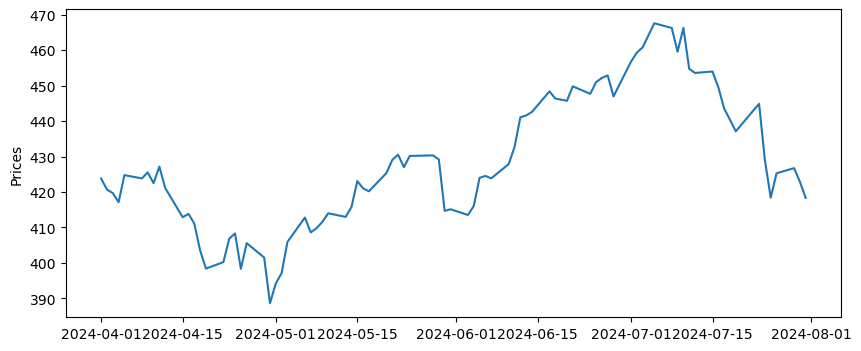

In [5]:
plt.figure(figsize=(10,4))
plt.plot(prices.dropna())
plt.ylabel('Prices')

Text(0, 0.5, 'Returns')

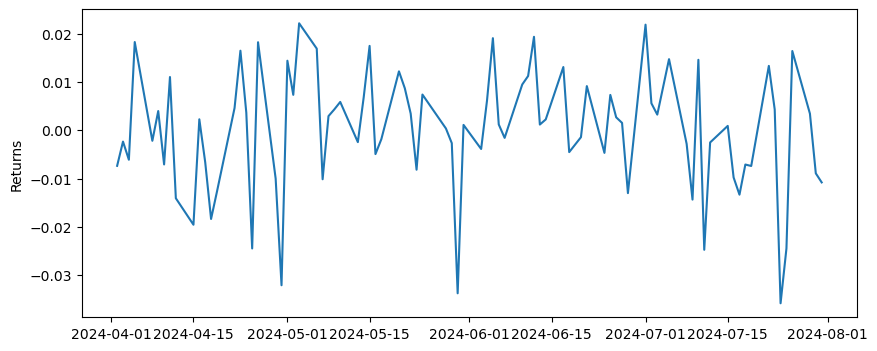

In [6]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Returns')

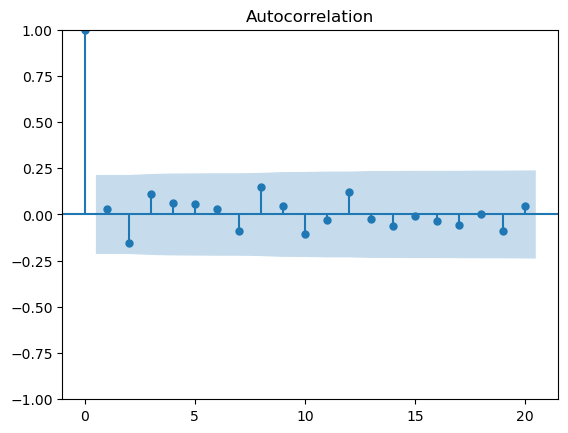

In [7]:
plot_acf = plot_acf(returns)

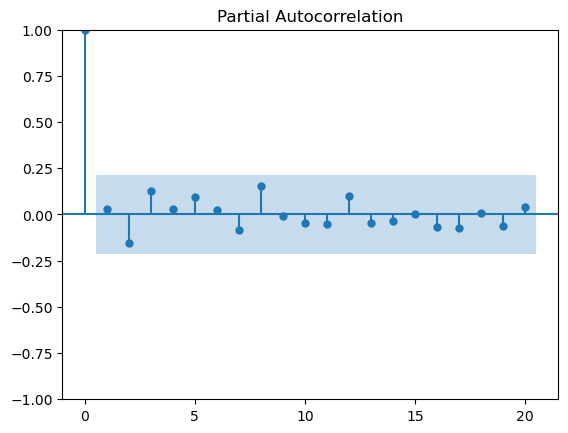

In [8]:
plot_pacf = plot_pacf(returns)

## Baseline model (random buying and selling)

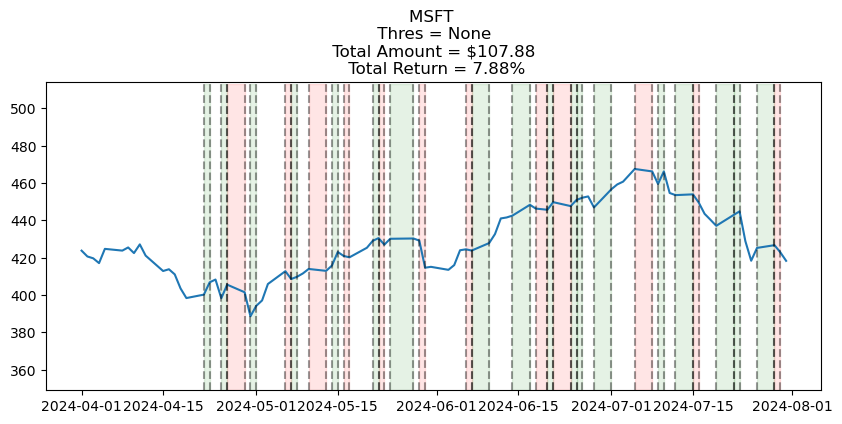

107.88293089039026

In [9]:
run_simulations(returns, prices, 100, 0.5, 0, verbose = False, plot = True)

#### This is one such instance of baseline model. We need to have a lot of these to make a statement


In [10]:
final_amt = [run_simulations(returns, prices, 100, 0.5, None , verbose = False, plot = False) for _ in range(10000)]

Text(0.5, 1.0, 'Avg amount $102.39 \n Std deviation $5.58')

<Figure size 800x300 with 0 Axes>

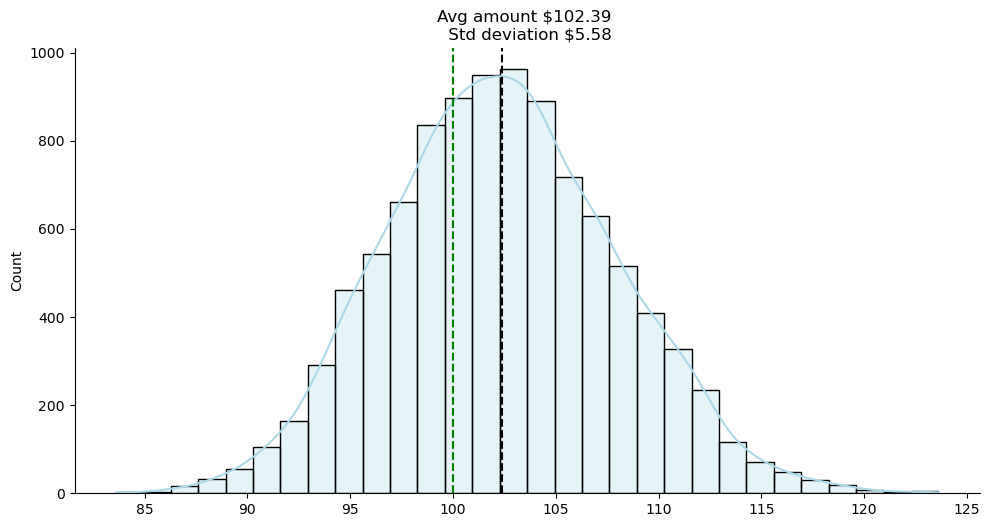

In [11]:
plt.figure(figsize=(8,3))
sns.displot(final_amt, bins=30, kde=True, color='lightblue', alpha=0.3, aspect=2)
plt.axvline(np.mean(final_amt), color = 'k', linestyle = '--')
plt.axvline(100, color = 'g', linestyle = '--')
plt.title(f'Avg amount ${np.mean(final_amt):.2f} \n Std deviation ${np.std(final_amt):.2f}' )

## If last return was positive, then 'buy'

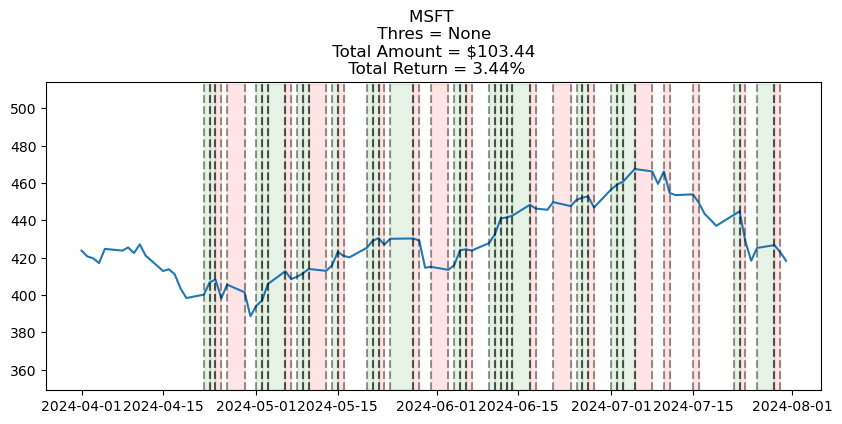

103.4446130797151

In [12]:
run_simulations(returns, prices, 100, 'last', None , verbose = False)

## Try ARMA model

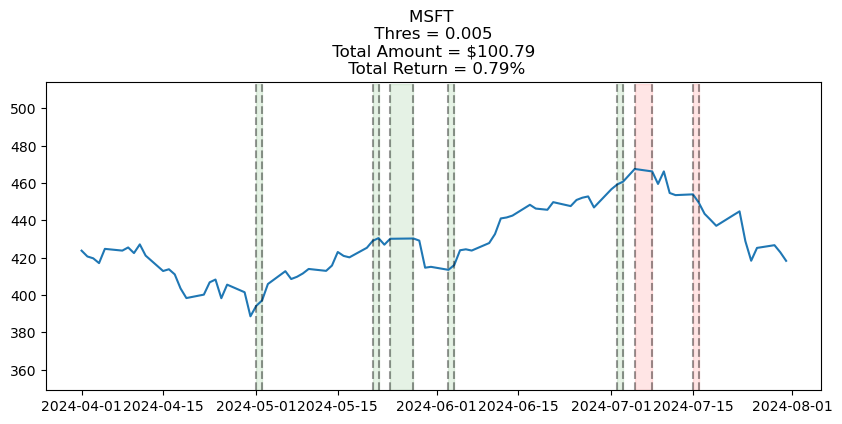

100.78932064079397

In [13]:
run_simulations(returns, prices, 100, (4,0,3), 0.005, verbose=False, plot = True)

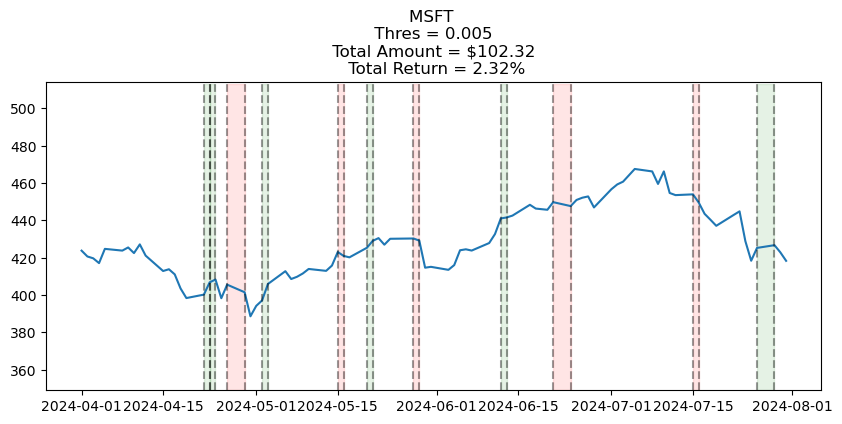

102.32340525165993

In [14]:
run_simulations(returns, prices, 100, (5,0,5), 0.005, verbose=False, plot = True)

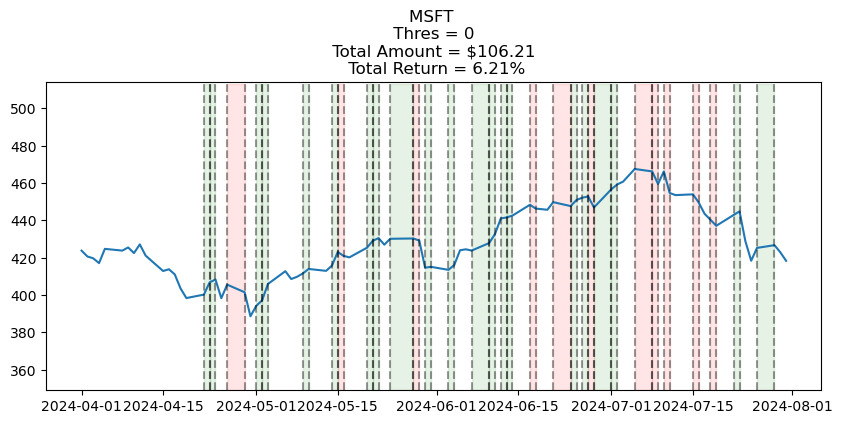

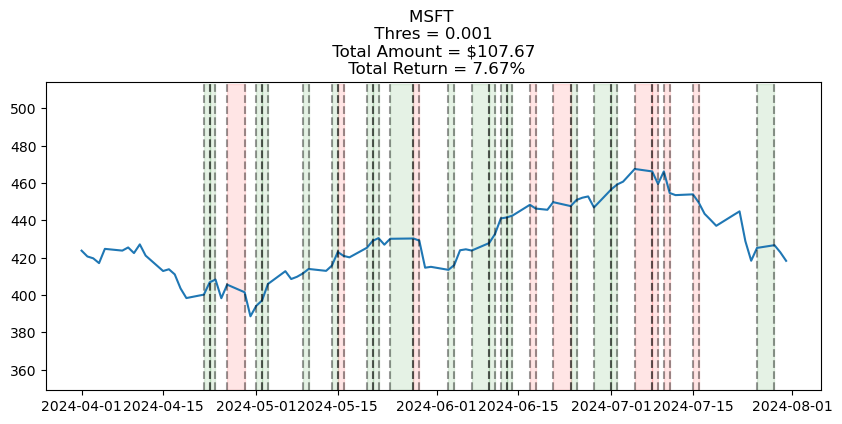

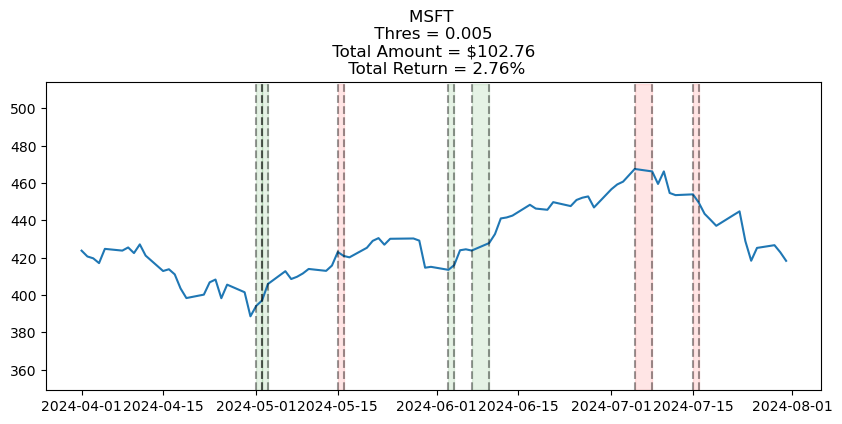

In [15]:
for thres in [0, 0.001, 0.005]:
    run_simulations(returns, prices, 100, (4,0,4), thres, verbose=False, plot = True)